In [43]:
import math 
import numpy as np
from scipy.linalg import sqrtm
import matplotlib.pyplot as plt
from tabulate import tabulate
import numpy as np
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import TimeSeriesSplit
import pandas as pd
def MSE(X, y):
    Mse = 0
    # Split using time series cross-validation (e.g., 5 splits)
    train_window = int(np.round(0.75 * len(X),0))  # Fixed size of training set (e.g., 75 time steps)
    test_window = 1   # Fixed size of test set (e.g., 25 time steps)
    # Sliding window cross-validation
    for i in range(0, len(X) - train_window - test_window + 1):
        X_train = X[i:i + train_window]
        y_train = y[i:i + train_window]
        X_test = X[i + train_window:i + train_window + test_window]
        y_test = y[i + train_window:i + train_window + test_window]
        model = LinearRegression()
        model.fit(X_train, y_train)
        # Make predictions
        y_pred = model.predict(X_test)
        # Calculate errors
        mse = mean_squared_error(y_test, y_pred)
        Mse += mse 
    Mse = Mse/(len(X) - train_window - test_window)
    return np.sqrt(Mse)    
    
def sir_1(X, y, H, K):
    """Sliced Inverse Regression : Method 1

        Parameters
        ----------
        X : float, array of shape [n_samples, dimension]
            The generated samples.

        y : int, array of shape [n_samples, ]
            Labels of each generated sample.

        H : number of slices

        K : return K estimated e.d.r directions

        Returns
        -------
        edr_est : estimated e.d.r directions
        """
    Z = X-np.mean(X, axis=0)

    width = (np.max(y) - np.min(y)) / H

    V_hat = np.zeros([X.shape[1], X.shape[1]])
    for h in range(H):
        h_index = np.logical_and(np.min(y)+h*width <= y, y < np.min(y)+(h+1)*width)
        ph_hat = np.mean(h_index)
        if ph_hat == 0:
            continue
        mh = np.mean(Z[h_index, :], axis=0)
        V_hat = np.add(V_hat,ph_hat * np.matmul(mh[:, np.newaxis], mh[np.newaxis, :]))

    # 特征值和特征向量（列向量）
    eigenvalues, eigenvectors = np.linalg.eig(V_hat)
    K_index = np.argpartition(np.abs(eigenvalues), X.shape[1]-K) >= X.shape[1]-K
    K_largest_eigenvectors = eigenvectors[:, K_index]
    edr_est =  K_largest_eigenvectors
    num_rows = 10
    num_cols = math.ceil(K/10)
#     fig, axes = plt.subplots(num_rows, num_cols, figsize=(100, 90))

    # 迭代生成子图并绘制散点图
#     for i in range(num_rows):
#         for j in range(num_cols):
#             if i * num_cols + j < K:  # 避免在多余的子图上绘制
#                 ax = axes[i, j]
#                 ax.scatter(np.matmul(X, edr_est[:,i * num_cols + j]), y)
#                 ax.set_title(titles[i * num_cols + j])
#                 ax.legend()
#             else:
#                 break
#     plt.tight_layout()

# 显示所有子图
#     plt.show()
    for k in range(K):
        if k==0:
            scatter_plot(x=np.matmul(X, edr_est[:, k]), y=y, x_name=str(k + 1) + "-st estimated direction", y_name="Y", title=None,
                     file_name="sir1_" + str(k + 1) + "-st_est_direction.png")
        else:
            scatter_plot(x=np.matmul(X, edr_est[:, k]), y=y, x_name=str(k + 1) + "-th estimated direction", y_name="Y", title=None,
                     file_name="sir1_" + str(k + 1) + "-th_est_direction.png")
    return edr_est,mh, V_hat


def sir_2(X, y, H, K):
    """Sliced Inverse Regression : Method 2

        Parameters
        ----------
        X : float, array of shape [n_samples, dimension]
            The generated samples.

        y : int, array of shape [n_samples, ]
            Labels of each generated sample.

        H : number of slices

        K : return K estimated e.d.r directions

        Returns
        -------
        edr_est : estimated e.d.r directions
        """
    cov_x = np.cov(X, rowvar=False)
    u = np.linalg.inv(cov_x)
    r = np.array(sqrtm(u))
    Z = np.matmul(X - np.mean(X, axis=0), r)

    width = (np.max(y) - np.min(y)) / H

    V_hat = np.zeros([X.shape[1], X.shape[1]])
    for h in range(H):
        h_index = np.logical_and(np.min(y) + h * width <= y, y < np.min(y) + (h + 1) * width)
        ph_hat = np.mean(h_index)
        if ph_hat == 0:
            continue
        V_hat = np.add(V_hat,np.matmul(Z[h_index, :].T, Z[h_index, :]) / ph_hat)

    V_hat = V_hat/(H*X.shape[0])
    # 特征值和特征向量（列向量）
    eigenvalues, eigenvectors = np.linalg.eig(V_hat)
    K_index = np.argpartition(np.abs(1-eigenvalues), X.shape[1]-K) >= X.shape[1]-K
    K_largest_eigenvectors = eigenvectors[:, K_index]
    edr_est = np.matmul(r, K_largest_eigenvectors)

    for k in range(K):
        if k==0:
            scatter_plot(x=np.matmul(X, edr_est[:, k]), y=y, x_name=str(k + 1) + "-st estimated direction", y_name="Y", title=None,
                     file_name="sir2_" + str(k + 1) + "-st_est_direction.png")
#         else:
#             scatter_plot(x=np.matmul(X, edr_est[:, k]), y=y, x_name=str(k + 1) + "-th estimated direction", y_name="Y", title=None,
#                      file_name="sir2_" + str(k + 1) + "-th_est_direction.png")

    return edr_est


def save(X, y, H, K):
    """Sliced Average Variance Estimates

        Parameters
        ----------
        X : float, array of shape [n_samples, dimension]
            The generated samples.

        y : int, array of shape [n_samples, ]
            Labels of each generated sample.

        H : number of slices

        K : return K estimated e.d.r directions

        Returns
        -------
        edr_est : estimated e.d.r directions
        """
    cov_x = np.cov(X, rowvar=False)
    u = np.linalg.inv(cov_x)
    r = np.array(sqrtm(u))
    Z = np.matmul(X - np.mean(X, axis=0), r)

    width = (np.max(y) - np.min(y)) / H

    V_hat = np.zeros([X.shape[1], X.shape[1]])
    for h in range(H):
        h_index = np.logical_and(np.min(y) + h * width <= y, y < np.min(y) + (h + 1) * width)
        ph_hat = np.mean(h_index)
        if ph_hat == 0:
            continue
        temp = np.eye(X.shape[1]) - np.matmul(Z[h_index, :].T, Z[h_index, :]) / (ph_hat*X.shape[0])
        V_hat =np.add(V_hat,np.matmul(temp, temp))

    # 特征值和特征向量（列向量）
    eigenvalues, eigenvectors = np.linalg.eig(V_hat)
    K_index = np.argpartition(np.abs(eigenvalues), X.shape[1]-K) >= X.shape[1]-K
    K_largest_eigenvectors = eigenvectors[:, K_index]
    edr_est = np.matmul(r, K_largest_eigenvectors)

    for k in range(K):
        if k==0:
            scatter_plot(x=np.matmul(X, edr_est[:, k]), y=y, x_name=str(k + 1) + "-st estimated direction", y_name="Y", title=None,
                     file_name="save_" + str(k + 1) + "-st_est_direction.png")
        else:
            scatter_plot(x=np.matmul(X, edr_est[:, k]), y=y, x_name=str(k + 1) + "-th estimated direction", y_name="Y", title=None,
                     file_name="save_" + str(k + 1) + "-th_est_direction.png")

    return edr_est


def scatter_plot(x, y, x_name, y_name, title, file_name, dpi=200):
    # 绘制二维图片
    origin_dpi = plt.rcParams['figure.dpi']
    plt.rcParams['figure.dpi'] = dpi
    plt.scatter(x, y, s=10, color="b", alpha=0.5)
    plt.title(title)
    plt.xlabel(x_name)
    plt.ylabel(y_name)
    plt.grid()
    plt.savefig(file_name)
    plt.close()
    plt.rcParams['figure.dpi'] = origin_dpi


def projection_matrix_F_norm(beta, beta_hat):
    P = beta @ np.linalg.inv(beta.T @ beta) @ beta.T
    P_hat = beta_hat @ np.linalg.inv(beta_hat.T @ beta_hat) @ beta_hat.T

    return np.linalg.norm(P-P_hat)

def affine_criterion(beta, beta_hat, cov_X):
    Rsquare1 = ((beta_hat @ cov_X @ beta.T)**2)/((beta_hat @ cov_X @ beta_hat) * (beta @ cov_X @ beta.T))
    
    return Rsquare1
# # example 1 : y = x_1 + x_2 + x_3 + x_4 + 0x_5 + epsilon
# n = 500
# H = 5
# K = 1
# beta = np.array([1, 1, 1, 1, 0])
# print('beta : ', beta)
# X = np.random.normal(0, 1, [n, 5])
# epsilon = np.random.normal(0, 1, n)
# y = np.matmul(X, beta) + epsilon
#
# print('SIR Method 1, beta_hat : ')
# sir_1_result = sir_1(X, y, H=H, K=K)
# print(sir_1_result)
# print('SIR Method 1, projection matrix F norm : ')
# print(projection_matrix_F_norm(beta[:, np.newaxis], sir_1_result))
#
# print('SIR Method 2, beta_hat : ')
# sir_2_result = sir_2(X, y, H=H, K=K)
# print(sir_2_result)
# print('SIR Method 2, projection matrix F norm : ')
# print(projection_matrix_F_norm(beta[:, np.newaxis], sir_2_result))
#
# print('SAVE, beta_hat : ')
# save_result = save(X, y, H=H, K=K)
# print(save_result)
# print('SAVE, projection matrix F norm : ')
# print(projection_matrix_F_norm(beta[:, np.newaxis], save_result))


# # example 2 : y = x_1 * ( x_1 + x_2 + 1 ) + sigma * epsilon
# n = 10000
# H = 20
# K = 2
# p = 10  # number of variables
# sigma = 0.5
# beta1 = np.concatenate([[1], np.zeros(p-1)])
# beta2 = np.concatenate([[0, 1], np.zeros(p-2)])
# beta = np.c_[beta1[:, np.newaxis], beta2[:, np.newaxis]]
# print('beta1 : ', beta1)
# print('beta2 : ', beta2)
# X = np.random.normal(0, 1, [n, p])
# epsilon = np.random.normal(0, sigma, n)
# y = np.matmul(X, beta1) * (np.matmul(X, beta1) + np.matmul(X, beta2) + 1.) + epsilon
#
# print('SIR Method 1, beta_hat : ')
# sir_1_result = sir_1(X, y, H=H, K=K)
# print(sir_1_result)
# print('SIR Method 1, projection matrix F norm : ')
# print(projection_matrix_F_norm(beta, sir_1_result))
#
# print('SIR Method 2, beta_hat : ')
# sir_2_result = sir_2(X, y, H=H, K=K)
# print(sir_2_result)
# print('SIR Method 2, projection matrix F norm : ')
# print(projection_matrix_F_norm(beta, sir_2_result))
#
# print('SAVE, beta_hat : ')
# save_result = save(X, y, H=H, K=K)
# print(save_result)
# print('SAVE, projection matrix F norm : ')
# print(projection_matrix_F_norm(beta, save_result))


# # example 3 : y = x_1 / ( 0.5 + ( x_2 + 1.5 )^2 ) + sigma * epsilon
# n = 10000
# H = 20
# K = 2
# p = 10  # number of variables
# sigma = 0.5
# beta1 = np.concatenate([[1], np.zeros(p-1)])
# beta2 = np.concatenate([[0, 1], np.zeros(p-2)])
# beta = np.c_[beta1[:, np.newaxis], beta2[:, np.newaxis]]
# print('beta1 : ', beta1)
# print('beta2 : ', beta2)
# X = np.random.normal(0, 1, [n, p])
# epsilon = np.random.normal(0, sigma, n)
# y = np.matmul(X, beta1) / (0.5 + np.power(np.matmul(X, beta2) + 1.5, 2)) + epsilon
#
# print('SIR Method 1, beta_hat : ')
# sir_1_result = sir_1(X, y, H=H, K=K)
# print(sir_1_result)
# print('SIR Method 1, projection matrix F norm : ')
# print(projection_matrix_F_norm(beta, sir_1_result))
#
# print('SIR Method 2, beta_hat : ')
# sir_2_result = sir_2(X, y, H=H, K=K)
# print(sir_2_result)
# print('SIR Method 2, projection matrix F norm : ')
# print(projection_matrix_F_norm(beta, sir_2_result))
#
# print('SAVE, beta_hat : ')
# save_result = save(X, y, H=H, K=K)
# print(save_result)
# print('SAVE, projection matrix F norm : ')
# print(projection_matrix_F_norm(beta, save_result))


# example 4 : y = x_1^2 + epsilon
# n = 1000
# H = 5
# K = 1
# v = 10
# beta = np.array([1, 0])
# print('beta : ', beta)
# X = np.zeros([n, 2])
# X[:, 0] = np.random.normal(0, 1, n)
# X[:, 1] = X[:, 0] * X[:, 0] + np.random.normal(0, v, n)
# epsilon = np.random.normal(0, 0.5, n)
# y = X[:, 0] * X[:, 0] + epsilon
#
# print('SIR Method 1, beta_hat : ')
# sir_1_result = sir_1(X, y, H=H, K=K)
# print(sir_1_result)
# print('SIR Method 1, projection matrix F norm : ')
# print(projection_matrix_F_norm(beta[:, np.newaxis], sir_1_result))
#
# print('SIR Method 2, beta_hat : ')
# sir_2_result = sir_2(X, y, H=H, K=K)
# print(sir_2_result)
# print('SIR Method 2, projection matrix F norm : ')
# print(projection_matrix_F_norm(beta[:, np.newaxis], sir_2_result))
#
# print('SAVE, beta_hat : ')
# save_result = save(X, y, H=H, K=K)
# print(save_result)
# print('SAVE, projection matrix F norm : ')
# print(projection_matrix_F_norm(beta[:, np.newaxis], save_result))

In [3]:
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
M = pd.read_csv(r'C:\\Users\\yhuang73\\Desktop\\RIGHT 104.csv')

In [4]:
N = M.drop(M.columns[0], axis=1)
N

,tON 01,Flow_Carrier Gas,tON 02,Flow_rate,Unnamed: 0,Unnamed: 4,TC_M8,TC_C7_Zone7,TC_M7_Zone7,TC_M1,...,TV_RZ_PO_PV,EVP1_1_PV,EVP1_2_PV,EVP1_3_PV,EVP1_4_PV,TEN1,TEN2,TEN3,TEN4,Ic(A)
0,10.041,1544.0,55.189,8.028,1176,1250.500000,271,272,272,277,...,25.97,280,276,275,276,1.5,1.2,1.7,2.2,6.53295
1,10.051,1542.2,55.105,8.055,1177,1250.516667,271,272,272,277,...,26.00,281,277,275,277,1.5,1.2,1.7,2.2,7.92975
2,10.068,1540.4,54.972,8.075,1178,1250.533333,271,272,272,277,...,25.96,281,277,275,277,1.5,1.2,1.7,2.3,19.48245
3,10.011,1550.4,54.812,8.059,1180,1250.566667,271,272,272,277,...,25.96,281,277,275,277,1.5,1.2,1.7,2.3,12.49845
4,10.100,1535.0,54.759,8.027,1182,1250.600000,271,272,272,277,...,26.00,281,277,276,277,1.5,1.2,1.7,2.3,14.01165
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
53372,10.949,1538.0,56.711,7.994,112431,3104.750000,272,272,273,276,...,29.53,280,276,276,276,1.8,0.2,3.1,2.4,12.07650
53373,10.961,1541.4,56.744,7.991,112434,3104.800000,272,272,273,276,...,29.88,280,276,276,276,1.8,0.2,3.0,2.3,8.32260
53374,10.927,1550.2,56.730,8.000,112436,3104.833333,272,272,273,276,...,29.89,280,276,276,276,1.7,0.2,2.9,2.3,12.20745
53375,10.897,1545.8,56.702,8.007,112438,3104.866667,272,272,273,276,...,29.82,280,276,277,276,1.7,0.2,2.8,2.2,8.68635


In [5]:
#data normalization
L = M.iloc[:, :-1]
# normalized_features = (features - features.mean()) / features.std()
columns_to_drop = []
for column in L.columns:
    if L[column].nunique() == 1:
        columns_to_drop.append(column)

L.drop(columns=columns_to_drop, inplace=True)

L = L.values

In [6]:
#data normalization
X = N.iloc[:, :-1]
# normalized_features = (features - features.mean()) / features.std()
y = M.iloc[:,-1]
columns_to_drop = []
for column in X.columns:
    if X[column].nunique() == 1:
        columns_to_drop.append(column)

X.drop(columns=columns_to_drop, inplace=True)

X = X.values
X = X.astype('float64')
X

array([[1.0041e+01, 1.5440e+03, 5.5189e+01, ..., 1.2000e+00, 1.7000e+00,
        2.2000e+00],
       [1.0051e+01, 1.5422e+03, 5.5105e+01, ..., 1.2000e+00, 1.7000e+00,
        2.2000e+00],
       [1.0068e+01, 1.5404e+03, 5.4972e+01, ..., 1.2000e+00, 1.7000e+00,
        2.3000e+00],
       ...,
       [1.0927e+01, 1.5502e+03, 5.6730e+01, ..., 2.0000e-01, 2.9000e+00,
        2.3000e+00],
       [1.0897e+01, 1.5458e+03, 5.6702e+01, ..., 2.0000e-01, 2.8000e+00,
        2.2000e+00],
       [1.0924e+01, 1.5426e+03, 5.6706e+01, ..., 2.0000e-01, 3.0000e+00,
        2.2000e+00]])

In [7]:
X.shape[1]

59

In [8]:
print(X.dtype)

float64


In [9]:
cov_x = np.cov(X, rowvar=False)
u = np.linalg.inv(cov_x)
r = np.array(sqrtm(u))
Z = np.matmul(X-np.mean(X, axis=0), r)

In [10]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X = scaler.fit_transform(X)

In [11]:
X

array([[ -1.89864557,  -0.06285344,  -0.34705394, ...,  19.02010513,
        -10.57383767,  -0.90196217],
       [ -1.87289753,  -0.52671115,  -0.47899531, ...,  19.02010513,
        -10.57383767,  -0.90196217],
       [ -1.82912587,  -0.99056887,  -0.68790249, ...,  19.02010513,
        -10.57383767,  -0.23315569],
       ...,
       [  0.3826306 ,   1.53487868,   2.07344202, ...,   0.27995939,
         -0.71399231,  -0.23315569],
       [  0.30538648,   0.40100427,   2.02946156, ...,   0.27995939,
         -1.53564609,  -0.90196217],
       [  0.37490618,  -0.42363166,   2.03574449, ...,   0.27995939,
          0.10766147,  -0.90196217]])

In [16]:
X.shape

(53377, 59)

In [12]:
y = y.values
y = y.astype('float64')
y

array([ 6.53295,  7.92975, 19.48245, ..., 12.20745,  8.68635,  8.0316 ])

In [13]:
import matplotlib 
# example 
#consider sparse case in the future
H = 500
K = 1
print('SIR Method 1, beta_hat : ')
# we do normalization in SIR first step
sir_1_result,mh,V_hat = sir_1(X, y, H=H, K=K)
print(sir_1_result)
#

SIR Method 1, beta_hat : 
[[ 0.22384631]
 [ 0.00041457]
 [ 0.21501567]
 [-0.00183771]
 [ 0.25056329]
 [ 0.25056329]
 [ 0.01544373]
 [-0.01000213]
 [ 0.04162086]
 [ 0.00655616]
 [-0.07822416]
 [-0.05927871]
 [-0.05624012]
 [-0.0319181 ]
 [-0.11405081]
 [-0.15100372]
 [-0.04101332]
 [-0.01099983]
 [ 0.08505187]
 [-0.16907379]
 [-0.10803336]
 [-0.18450124]
 [-0.17914586]
 [-0.0914068 ]
 [-0.20235614]
 [-0.18855775]
 [-0.1448615 ]
 [-0.11920337]
 [-0.13762167]
 [-0.10929093]
 [ 0.03788806]
 [ 0.11815537]
 [-0.00105682]
 [ 0.01907005]
 [ 0.12645358]
 [ 0.05834861]
 [ 0.00698229]
 [ 0.00698229]
 [-0.00926442]
 [-0.13970579]
 [-0.13970579]
 [ 0.22712005]
 [-0.23130113]
 [-0.241846  ]
 [-0.25408905]
 [-0.25263174]
 [-0.04762974]
 [-0.18230704]
 [-0.21359105]
 [ 0.0042333 ]
 [ 0.05910543]
 [-0.02186056]
 [-0.01331069]
 [-0.002145  ]
 [ 0.03667775]
 [-0.00307276]
 [-0.07192398]
 [ 0.0426007 ]
 [-0.00451195]]


In [65]:
# first-order differencing
data_diff = np.diff(X, axis=0)

In [66]:
data_diff

array([[ 0.02574804, -0.46385771, -0.13194138, ...,  0.        ,
         0.        ,  0.        ],
       [ 0.04377166, -0.46385771, -0.20890718, ...,  0.        ,
         0.        ,  0.66880649],
       [-0.14676382,  2.57698729, -0.25131691, ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [-0.08754333,  2.26774881, -0.02199023, ...,  0.        ,
        -0.82165378,  0.        ],
       [-0.07724411, -1.13387441, -0.04398046, ...,  0.        ,
        -0.82165378, -0.66880649],
       [ 0.0695197 , -0.82463593,  0.00628292, ...,  0.        ,
         1.64330756,  0.        ]])

In [67]:
# fit AR Model for Each Column or Vector Autoregression (VAR)
import numpy as np
import statsmodels.api as sm
from statsmodels.tsa.ar_model import AutoReg
# Load or generate your time series data (y)
# y = np.random.randn(100)  # Example time series data
# Fit an AR model of order p (e.g., p=2)
# Example matrix data (each column is a time series)
data = data_diff  # 100 time points, 3 time series
# Fit AR model for each column (time series)
results = []
lags = 4
for i in range(data.shape[1]):
    model = AutoReg(data[:, i], lags)
    result = model.fit()
    results.append(result.fittedvalues)
    print(f"Series {i+1} AR Coefficients: {result.params}")

Series 1 AR Coefficients: [ 9.46201644e-05 -5.75435246e-01 -3.67859317e-01 -2.24313132e-01
 -1.18269758e-01]
Series 2 AR Coefficients: [ 4.33703428e-05 -9.69880692e-01 -7.91599243e-01 -5.27642512e-01
 -2.48612157e-01]
Series 3 AR Coefficients: [ 8.60821743e-05 -1.21731511e-01 -2.35436952e-01 -1.13985222e-01
 -9.67158487e-02]
Series 4 AR Coefficients: [-0.00060493 -0.59793079 -0.57095066 -0.38679899 -0.23709911]
Series 5 AR Coefficients: [ 7.36654023e-05 -8.38091062e-02 -7.32675871e-02 -7.49920795e-02
  9.73576518e-02]
Series 6 AR Coefficients: [ 7.36654196e-05 -8.38092860e-02 -7.32669720e-02 -7.49925796e-02
  9.73574495e-02]
Series 7 AR Coefficients: [ 4.51362641e-05 -2.35921429e-03 -2.39659269e-02 -6.51447192e-02
 -1.25552411e-02]
Series 8 AR Coefficients: [0. 0. 0. 0. 0.]
Series 9 AR Coefficients: [ 5.14256929e-05 -3.47892936e-05 -1.05274551e-02 -2.62508712e-03
 -2.73533765e-03]
Series 10 AR Coefficients: [-3.62289305e-05 -4.03085215e-05 -5.49468850e-03 -5.48471646e-03
 -1.85854473e-

In [68]:
results

[array([-0.09064604,  0.00873292,  0.10254908, ..., -0.06731928,
         0.01233649,  0.05184972]),
 array([ 2.16920403, -0.40227518, -3.07272412, ...,  0.45768697,
        -2.08055252, -0.69640685]),
 array([ 0.10596252,  0.07637646,  0.05229419, ..., -0.01303517,
        -0.01439416,  0.00334165]),
 array([ 3.36084986,  5.96965749,  6.49069719, ...,  0.95512657,
        -0.62685843, -1.99891652]),
 array([6.45782692e-05, 6.22427947e-05, 6.52747991e-05, ...,
        6.26647364e-05, 6.29930304e-05, 6.29393246e-05]),
 array([6.45784068e-05, 6.22426848e-05, 6.52749090e-05, ...,
        6.26646231e-05, 6.29932704e-05, 6.29391903e-05]),
 array([4.51362641e-05, 4.51362641e-05, 4.51362641e-05, ...,
        4.51362641e-05, 4.51362641e-05, 4.51362641e-05]),
 array([0., 0., 0., ..., 0., 0., 0.]),
 array([5.14256929e-05, 5.14256929e-05, 5.14256929e-05, ...,
        5.14256929e-05, 5.14256929e-05, 5.14256929e-05]),
 array([-3.62289305e-05, -3.62289305e-05, -3.62289305e-05, ...,
        -3.622893

In [69]:
X1 = np.array(results)

In [71]:
X1.shape

(59, 53372)

In [77]:
sir_1_result1,mh,V_hat = sir_1(X1.T, y[:-lags-1], H=H, K=K)
sir_1_result1 = np.real(sir_1_result1)
sir_1_result1

C:\Users\yhuang73\AppData\Roaming\Python\Python312\site-packages\matplotlib\cbook.py:1699: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
C:\Users\yhuang73\AppData\Roaming\Python\Python312\site-packages\matplotlib\collections.py:194: ComplexWarning: Casting complex values to real discards the imaginary part
  offsets = np.asanyarray(offsets, float)


array([[ 2.77367708e-02],
       [-9.69357676e-01],
       [-3.65247682e-04],
       [-2.25851352e-01],
       [ 9.12591953e-08],
       [ 9.12668359e-08],
       [-6.24827599e-04],
       [ 0.00000000e+00],
       [-4.61699772e-05],
       [-2.35222564e-05],
       [-7.53198934e-09],
       [-4.72692495e-06],
       [ 7.95683652e-05],
       [ 1.67254535e-09],
       [-1.33379340e-04],
       [-4.02036450e-04],
       [-1.25645002e-05],
       [ 6.42522041e-05],
       [ 8.57099877e-06],
       [-3.65651383e-04],
       [-3.62323027e-05],
       [ 3.75762095e-04],
       [ 5.62191707e-08],
       [-1.05927018e-04],
       [-3.79959313e-06],
       [ 1.06115843e-04],
       [-1.93854031e-05],
       [-4.80129501e-05],
       [ 6.83311105e-07],
       [-3.90612904e-06],
       [ 1.49747442e-03],
       [ 1.97846118e-05],
       [ 1.43799628e-04],
       [-7.00219693e-04],
       [ 3.53611985e-05],
       [-2.87233757e-05],
       [ 7.77609686e-04],
       [ 7.77609686e-04],
       [ 1.3

In [78]:
sir_1_result1.shape

(59, 1)

In [ ]:
MSE(sir_1_result1 * X1, y)

In [85]:
MSE((sir_1_result1 * X1)[50:53200], y[50:53200])

8.161736737756529

In [ ]:
MSE(sir_1_result * X.T, y)

In [88]:
MSE((sir_1_result * X.T)[50:53200], y[50:53200])

17.17603655431585

In [ ]:
# Outliers begin from 20-50 time points???

In [80]:
sir_1_result * X.T

array([[-4.25004798e-01, -4.19241195e-01, -4.09443070e-01, ...,
         8.56504456e-02,  6.83596360e-02,  8.39213646e-02],
       [-2.60571495e-05, -2.18358625e-04, -4.10660100e-04, ...,
         6.36314599e-04,  1.66244326e-04, -1.75624964e-04],
       [-7.46220356e-02, -1.02991499e-01, -1.47909817e-01, ...,
         4.45822530e-01,  4.36366042e-01,  4.37716969e-01],
       ...,
       [-1.36800159e+00, -1.36800159e+00, -1.36800159e+00, ...,
        -2.01357923e-02, -2.01357923e-02, -2.01357923e-02],
       [-4.50452866e-01, -4.50452866e-01, -4.50452866e-01, ...,
        -3.04165706e-02, -6.54195952e-02,  4.58645398e-03],
       [ 4.06961261e-03,  4.06961261e-03,  1.05198793e-03, ...,
         1.05198793e-03,  4.06961261e-03,  4.06961261e-03]])

In [81]:
sir_1_result1 * X1

array([[-2.51422845e-03,  2.42222937e-04,  2.84438044e-03, ...,
        -1.86721952e-03,  3.42174359e-04,  1.43814390e-03],
       [-2.10273458e+00,  3.89948535e-01,  2.97856872e+00, ...,
        -4.43662377e-01,  2.01679956e+00,  6.75067325e-01],
       [-3.87025630e-05, -2.78963253e-05, -1.91003318e-05, ...,
         4.76106677e-06,  5.25743364e-06, -1.22052945e-06],
       ...,
       [ 1.01493213e-05,  1.01493213e-05,  1.01493213e-05, ...,
         1.01493213e-05,  1.01493213e-05,  1.01493213e-05],
       [ 2.86154559e-06,  2.86154559e-06,  2.86154559e-06, ...,
        -1.53766488e-03, -7.34245044e-04,  2.82118145e-03],
       [ 7.46477723e-05, -2.36921989e-05, -5.09881204e-08, ...,
        -9.41525158e-04, -3.97823379e-04, -6.69509077e-04]])

In [21]:
x=np.matmul(X, sir_1_result)

In [27]:
x.shape

(53377, 1)

In [28]:
y.shape

(53377,)

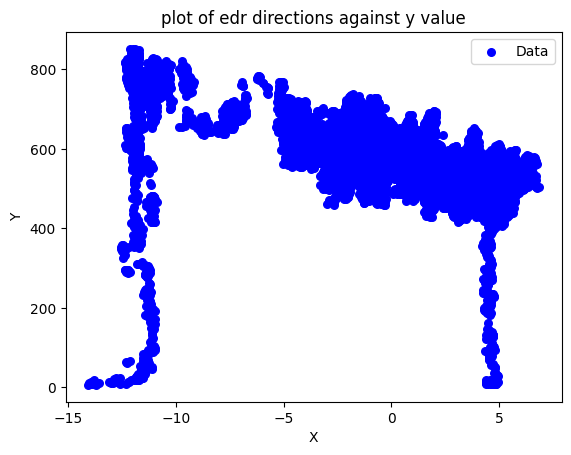

In [26]:
plt.scatter(x, y, color='blue', s=30, marker='o', label='Data')
# plt.plot(X_pred, y_pred, color='red', label='plot of edr directions against y value')
plt.xlabel('x')
plt.ylabel('y')
plt.title('plot of edr directions against y value')
plt.legend()
plt.show()

In [22]:
from sklearn.metrics import r2_score
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import numpy as np
import matplotlib.pyplot as plt
#consider dropout regions
# 创建示例数据
X1 = x[52900:53200]
y1 = y[52900:53200]
# 定义核函数（高斯核）
def gaussian_kernel(x1, x2, bandwidth):
    return np.exp(-0.5 * ((x1 - x2) / bandwidth) ** 2)

# 定义核回归函数
def kernel_regression(x_pred, X1, y1, bandwidth):
    num_samples = X1.shape[0]
    y_pred = np.zeros_like(x_pred)
    
    for i in range(x_pred.shape[0]):
        weighted_sum = 0.0
        total_weight = 0.0       
        for j in range(num_samples):
            weight = gaussian_kernel(x_pred[i], X1[j], bandwidth)
            weighted_sum += weight * y1[j]
            total_weight += weight
        
        y_pred[i] = weighted_sum / total_weight
    
    return y_pred

# 生成一组新的输入点
X_pred = X1

# 使用核回归函数估计回归值
for i in range(1,10):
    bandwidth = 0.000001 * i # 核带宽参数

    y_pred = kernel_regression(X1, X1, y1, bandwidth)

# 绘制核回归的拟合曲线
# plt.scatter(X1, y1, color='blue', s=30, marker='o', label='Data')
# plt.plot(X_pred, y_pred, color='red', label='Kernel Regression Fit')
# plt.xlabel('X')
# plt.ylabel('Y')
# plt.title('Kernel Regression Fit')
# plt.legend()
# plt.show()
mse = mean_squared_error(y1, y_pred)
print("MSE:", mse)
r_squared = r2_score(y1, y_pred)
print("R-squared:", r_squared)

MSE: 0.0
R-squared: 1.0
MSE: 2.9993913669761348e-25
R-squared: 1.0
MSE: 5.642370206852304e-11
R-squared: 0.9999999999999686
MSE: 5.566303215237432e-06
R-squared: 0.9999999969040602
MSE: 0.0011228352940665907
R-squared: 0.9999993754866755
MSE: 0.019139491907062923
R-squared: 0.9999893547452746
MSE: 0.09926722542354062
R-squared: 0.9999447882469584
MSE: 0.27288887763557684
R-squared: 0.9998482210693861
MSE: 0.5243114713180385
R-squared: 0.9997083815393476


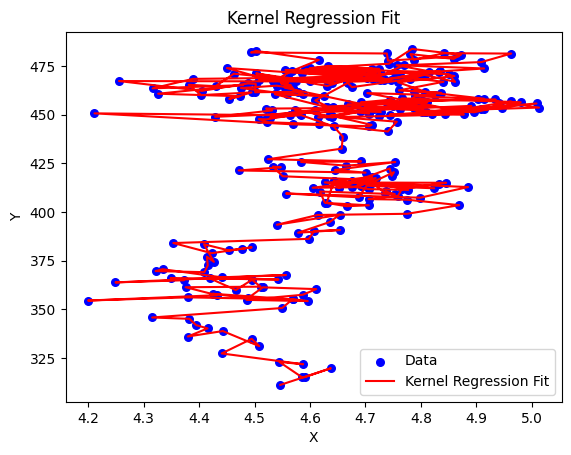

MSE: 0.0
R-squared: 1.0


In [19]:
#low quantile region
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
#consider dropout regions

X1 = x[52900:53200]
y1 = y[52900:53200]

def gaussian_kernel(x1, x2, bandwidth):
    return np.exp(-0.5 * ((x1 - x2) / bandwidth) ** 2)

def kernel_regression(x_pred, X1, y1, bandwidth):
    num_samples = X1.shape[0]
    y_pred = np.zeros_like(x_pred)
    
    for i in range(x_pred.shape[0]):
        weighted_sum = 0.0
        total_weight = 0.0       
        for j in range(num_samples):
            weight = gaussian_kernel(x_pred[i], X1[j], bandwidth)
            weighted_sum += weight * y1[j]
            total_weight += weight
        
        y_pred[i] = weighted_sum / total_weight
    
    return y_pred

X_pred = X1

bandwidth = 0.000001 
y_pred = kernel_regression(X1, X1, y1, bandwidth)

plt.scatter(X1, y1, color='blue', s=30, marker='o', label='Data')
plt.plot(X_pred, y_pred, color='red', label='Kernel Regression Fit')
plt.xlabel('X')
plt.ylabel('Y')
plt.title('Kernel Regression Fit')
plt.legend()
plt.show()

mse = mean_squared_error(y1, y_pred)
print("MSE:", mse)
r_squared = r2_score(y1, y_pred)
print("R-squared:", r_squared)

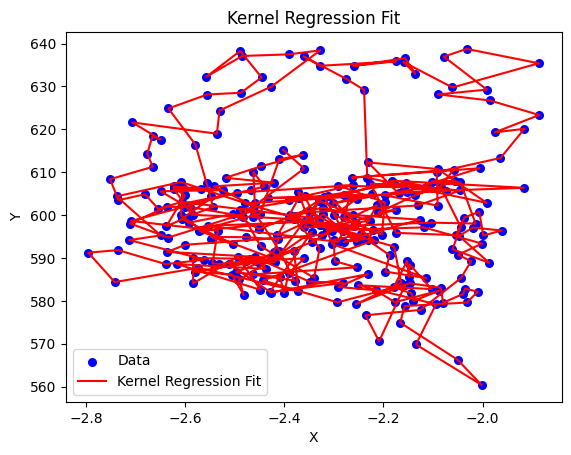

MSE: 0.0011544068510297644
R-squared: 0.9999943692015483


In [20]:
#low quantile region
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
#consider dropout regions

X1 = x[10000:10300]
y1 = y[10000:10300]

def gaussian_kernel(x1, x2, bandwidth):
    return np.exp(-0.5 * ((x1 - x2) / bandwidth) ** 2)

def kernel_regression(x_pred, X1, y1, bandwidth):
    num_samples = X1.shape[0]
    y_pred = np.zeros_like(x_pred)
    
    for i in range(x_pred.shape[0]):
        weighted_sum = 0.0
        total_weight = 0.0       
        for j in range(num_samples):
            weight = gaussian_kernel(x_pred[i], X1[j], bandwidth)
            weighted_sum += weight * y1[j]
            total_weight += weight
        
        y_pred[i] = weighted_sum / total_weight
    
    return y_pred

X_pred = X1

bandwidth = 0.000001 
y_pred = kernel_regression(X1, X1, y1, bandwidth)

plt.scatter(X1, y1, color='blue', s=30, marker='o', label='Data')
plt.plot(X_pred, y_pred, color='red', label='Kernel Regression Fit')
plt.xlabel('X')
plt.ylabel('Y')
plt.title('Kernel Regression Fit')
plt.legend()
plt.show()

mse = mean_squared_error(y1, y_pred)
print("MSE:", mse)
r_squared = r2_score(y1, y_pred)
print("R-squared:", r_squared)

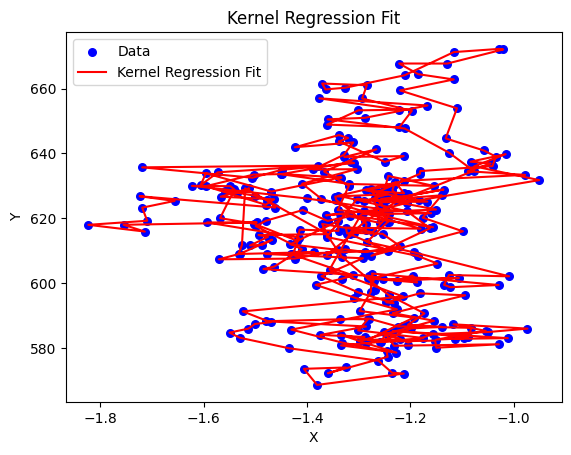

MSE: 0.024056764393709084
R-squared: 0.9999535385989532


In [29]:
#low quantile region
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
#consider dropout regions

X1 = x[20000:20300]
y1 = y[20000:20300]

def gaussian_kernel(x1, x2, bandwidth):
    return np.exp(-0.5 * ((x1 - x2) / bandwidth) ** 2)

def kernel_regression(x_pred, X1, y1, bandwidth):
    num_samples = X1.shape[0]
    y_pred = np.zeros_like(x_pred)
    
    for i in range(x_pred.shape[0]):
        weighted_sum = 0.0
        total_weight = 0.0       
        for j in range(num_samples):
            weight = gaussian_kernel(x_pred[i], X1[j], bandwidth)
            weighted_sum += weight * y1[j]
            total_weight += weight
        
        y_pred[i] = weighted_sum / total_weight
    
    return y_pred

X_pred = X1

bandwidth = 0.000001 
y_pred = kernel_regression(X1, X1, y1, bandwidth)

plt.scatter(X1, y1, color='blue', s=30, marker='o', label='Data')
plt.plot(X_pred, y_pred, color='red', label='Kernel Regression Fit')
plt.xlabel('X')
plt.ylabel('Y')
plt.title('Kernel Regression Fit')
plt.legend()
plt.show()

mse = mean_squared_error(y1, y_pred)
print("MSE:", mse)
r_squared = r2_score(y1, y_pred)
print("R-squared:", r_squared)

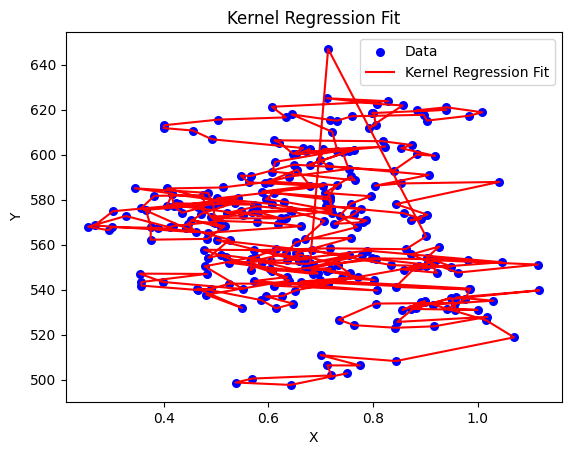

MSE: 5.897084901313833e-14
R-squared: 0.9999999999999999


In [35]:
#low quantile region
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
#consider dropout regions

X1 = x[30000:30300]
y1 = y[30000:30300]

def gaussian_kernel(x1, x2, bandwidth):
    return np.exp(-0.5 * ((x1 - x2) / bandwidth) ** 2)

def kernel_regression(x_pred, X1, y1, bandwidth):
    num_samples = X1.shape[0]
    y_pred = np.zeros_like(x_pred)
    
    for i in range(x_pred.shape[0]):
        weighted_sum = 0.0
        total_weight = 0.0       
        for j in range(num_samples):
            weight = gaussian_kernel(x_pred[i], X1[j], bandwidth)
            weighted_sum += weight * y1[j]
            total_weight += weight
        
        y_pred[i] = weighted_sum / total_weight
    
    return y_pred

X_pred = X1

bandwidth = 0.0000002 
y_pred = kernel_regression(X1, X1, y1, bandwidth)

plt.scatter(X1, y1, color='blue', s=30, marker='o', label='Data')
plt.plot(X_pred, y_pred, color='red', label='Kernel Regression Fit')
plt.xlabel('X')
plt.ylabel('Y')
plt.title('Kernel Regression Fit')
plt.legend()
plt.show()

mse = mean_squared_error(y1, y_pred)
print("MSE:", mse)
r_squared = r2_score(y1, y_pred)
print("R-squared:", r_squared)

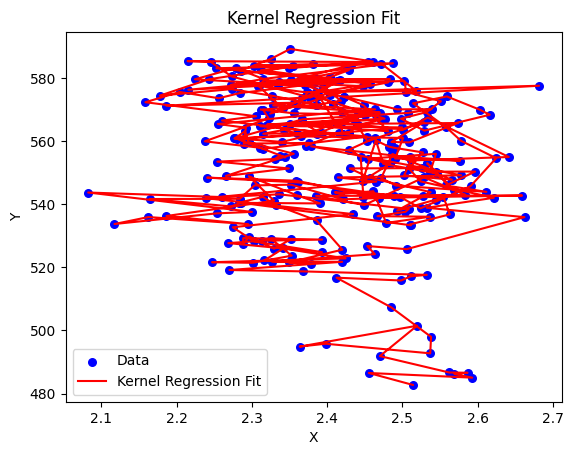

MSE: 2.614273838076541e-07
R-squared: 0.9999999994661319


In [37]:
#low quantile region
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
#consider dropout regions

X1 = x[40000:40300]
y1 = y[40000:40300]

def gaussian_kernel(x1, x2, bandwidth):
    return np.exp(-0.5 * ((x1 - x2) / bandwidth) ** 2)

def kernel_regression(x_pred, X1, y1, bandwidth):
    num_samples = X1.shape[0]
    y_pred = np.zeros_like(x_pred)
    
    for i in range(x_pred.shape[0]):
        weighted_sum = 0.0
        total_weight = 0.0       
        for j in range(num_samples):
            weight = gaussian_kernel(x_pred[i], X1[j], bandwidth)
            weighted_sum += weight * y1[j]
            total_weight += weight
        
        y_pred[i] = weighted_sum / total_weight
    
    return y_pred

X_pred = X1

bandwidth = 0.000001
y_pred = kernel_regression(X1, X1, y1, bandwidth)

plt.scatter(X1, y1, color='blue', s=30, marker='o', label='Data')
plt.plot(X_pred, y_pred, color='red', label='Kernel Regression Fit')
plt.xlabel('X')
plt.ylabel('Y')
plt.title('Kernel Regression Fit')
plt.legend()
plt.show()

mse = mean_squared_error(y1, y_pred)
print("MSE:", mse)
r_squared = r2_score(y1, y_pred)
print("R-squared:", r_squared)

MSE: 4271.057711821435


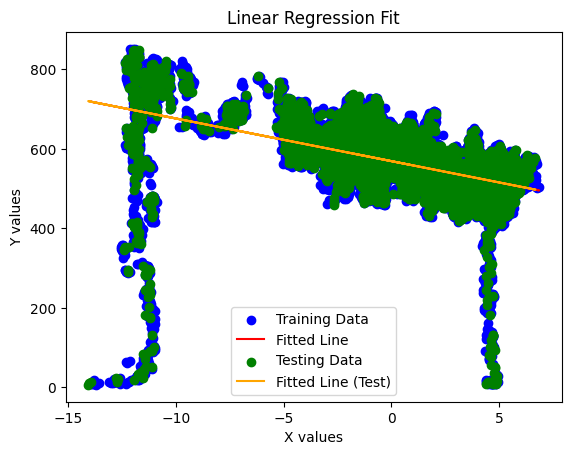

In [20]:
#linear regression
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import numpy as np

X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

model = LinearRegression()
model.fit(X_train, y_train)

y_train_pred = model.predict(X_train)
y_pred = model.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
print("MSE:", mse)

plt.scatter(X_train, y_train, color='blue', label='Training Data')  
plt.plot(X_train, y_train_pred, color='red', label='Fitted Line')  

plt.scatter(X_test, y_test, color='green', label='Testing Data')  
plt.plot(X_test, y_pred, color='orange', label='Fitted Line (Test)')  
plt.xlabel('X values')  
plt.ylabel('Y values')  
plt.title('Linear Regression Fit')  
plt.legend()  
plt.savefig('LR.png')
plt.show() 

MSE: 4271.057711821435


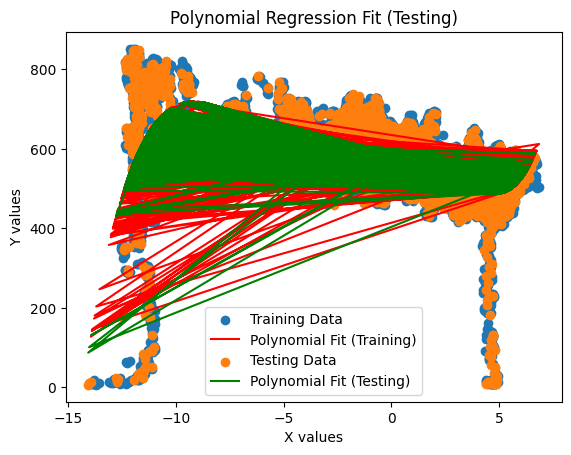

In [21]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
import numpy as np
import matplotlib.pyplot as plt

X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

poly = PolynomialFeatures(degree=6)  
X_train_poly = poly.fit_transform(X_train)
X_test_poly = poly.transform(X_test)


model = LinearRegression()
model.fit(X_train_poly, y_train)


y_train_pred = model.predict(X_train_poly)
y_test_pred = model.predict(X_test_poly)

mse = mean_squared_error(y_test, y_pred)
print("MSE:", mse)

plt.scatter(X_train, y_train, label='Training Data')
plt.plot(X_train, y_train_pred, color='red', label='Polynomial Fit (Training)')
plt.xlabel('X values')
plt.ylabel('Y values')
plt.title('Polynomial Regression Fit (Training)')
plt.legend()

plt.scatter(X_test, y_test, label='Testing Data')
plt.plot(X_test, y_test_pred, color='green', label='Polynomial Fit (Testing)')
plt.xlabel('X values')
plt.ylabel('Y values')
plt.title('Polynomial Regression Fit (Testing)')
plt.legend()
plt.savefig('PLR.png')
plt.show()


MSE: 4271.057711821435


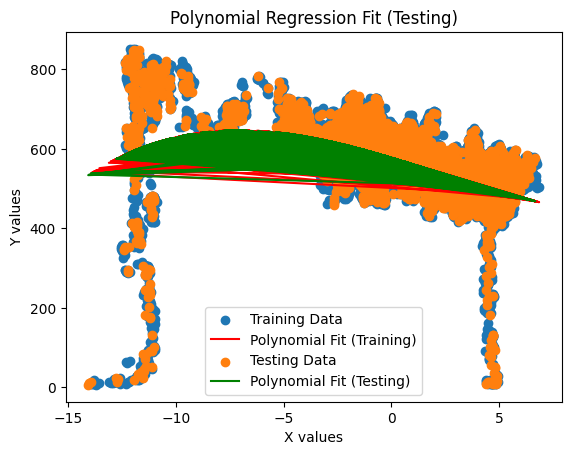

In [22]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
import numpy as np
import matplotlib.pyplot as plt

X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

poly = PolynomialFeatures(degree=3)  
X_train_poly = poly.fit_transform(X_train)
X_test_poly = poly.transform(X_test)


model = LinearRegression()
model.fit(X_train_poly, y_train)


y_train_pred = model.predict(X_train_poly)
y_test_pred = model.predict(X_test_poly)

mse = mean_squared_error(y_test, y_pred)
print("MSE:", mse)

plt.scatter(X_train, y_train, label='Training Data')
plt.plot(X_train, y_train_pred, color='red', label='Polynomial Fit (Training)')
plt.xlabel('X values')
plt.ylabel('Y values')
plt.title('Polynomial Regression Fit (Training)')
plt.legend()

plt.scatter(X_test, y_test, label='Testing Data')
plt.plot(X_test, y_test_pred, color='green', label='Polynomial Fit (Testing)')
plt.xlabel('X values')
plt.ylabel('Y values')
plt.title('Polynomial Regression Fit (Testing)')
plt.legend()
plt.savefig('PLR.png')
plt.show()